# Mapping with the MappingPulseTemplate

We will now have a look on how to remap parameters, channel ids and measurements. The definition of measurements is illustrated in [Definition of Measurements](08Measurements.ipynb). The `MappingPulseTemplate` class allows us to take any already existing `PulseTemplate` and specify a mapping for its parameters, channel ids and measurements. 

This can be useful for simply renaming things, e.g., to avoid name collisions of parameters or change the name of a channel a pulse should be executed on, but can also be employed to derive the value of certain parameters from other parameters.

## Mapping Parameters

In [1]:
from qctoolkit.pulses import MappingPT, FunctionPT, SequencePT, AtomicMultiChannelPT

sine = FunctionPT('a*sin(omega*t)', 't_duration')

my_parameter_mapping = dict(t_duration='2*pi/omega', omega='omega', a='a')

single_period_sine = MappingPT(sine, parameter_mapping=my_parameter_mapping)

print(single_period_sine.duration)
print(single_period_sine.parameter_names)

2*pi/omega
{'omega', 'a'}


Notice that we had to give mappings for all parameters, not only for the ones which changed. If we omit some of the encapsulated pulse tempaltes parameters an `MissingMappingException` is raised. This is done to enforce active thinking.

You can, however, allow partial parameter mappings by passing `allow_partial_paramter_mappings=True` to the constructor.

In [2]:
partial_parameter_mapping = dict(t_duration='2*pi/omega')
print('we expect an exception here:')
try:
    single_period_sine = MappingPT(sine, parameter_mapping=partial_parameter_mapping)
except Exception as exception:
    print(type(exception).__name__, ':',  exception)
print('')

print('no exception with allow_partial_parameter_mapping=True')
single_period_sine = MappingPT(sine, parameter_mapping=partial_parameter_mapping, allow_partial_parameter_mapping=True)
print(single_period_sine.duration)
print(single_period_sine.parameter_names)

we expect an exception here:
MissingMappingException : The template <qctoolkit.pulses.function_pulse_template.FunctionPulseTemplate object at 0x000000000524EDD8> needs a mapping function for parameter(s) {'omega', 'a'}

no exception with allow_partial_parameter_mapping=True
2*pi/omega
{'omega', 'a'}


## Mapping of Channel Ids and Measurement Names

Sometimes it is necessary to rename channels or measurements. Here we see a case where we want to play a sine and a cosine in parallel by using the `AtomicMultiChannelPulseTemplate` (for a more in depth explanation of multi-channel pulse template, see [Multi-Channel Pulses](07MultiChannelTemplates.ipynb)). Of course, this doesn't work as both pulses are by default defined on the 'default' channel.

In [3]:
sine_measurements = [('M', 't_duration/2', 't_duration')]
sine = FunctionPT('a*sin(omega*t)', 't_duration', measurements=sine_measurements)

cos_measurements = [('M', 0, 't_duration/2')]
cos = FunctionPT('a*cos(omega*t)', 't_duration', measurements=cos_measurements)

try:
    both = AtomicMultiChannelPT(sine, cos)
except Exception as exception:
    print(type(exception).__name__, ':', exception)

ChannelMappingException : Channel <default> is defined in subtemplate 1 and subtemplate 2


The solution is to use the `MappingPT` and rename the channels as we see in the next cell. Additionally, we want to distinguish between the measurements, so we rename them, too. 

In [4]:
cos_channel_mapping = dict(default='cos_channel')
cos_measurement_mapping = dict(M='M_cos')
remapped_cos = MappingPT(cos, channel_mapping=cos_channel_mapping, measurement_mapping=cos_measurement_mapping)
print('remapped_cos channels:', remapped_cos.defined_channels)
print('remapped_cos measurements:', remapped_cos.measurement_names)
print()

sine_channel_mapping = dict(default='sin_channel')
sine_measurement_mapping = dict(M='M_sin')
remapped_sine = MappingPT(sine, measurement_mapping=sine_measurement_mapping, channel_mapping=sine_channel_mapping)
print('remapped_sine channels:', remapped_sine.defined_channels)
print('remapped_sine measurements:', remapped_sine.measurement_names)
print()

both = AtomicMultiChannelPT(remapped_sine, remapped_cos)
print(both.defined_channels)
print(both.measurement_names)

remapped_cos channels: {'cos_channel'}
remapped_cos measurements: {'M_cos'}

remapped_sine channels: {'sin_channel'}
remapped_sine measurements: {'M_sin'}

{'cos_channel', 'sin_channel'}
{'M_sin', 'M_cos'}


Let's also plot it to see if it looks like expected with some dummy values for our parameters:

<IPython.core.display.Javascript object>


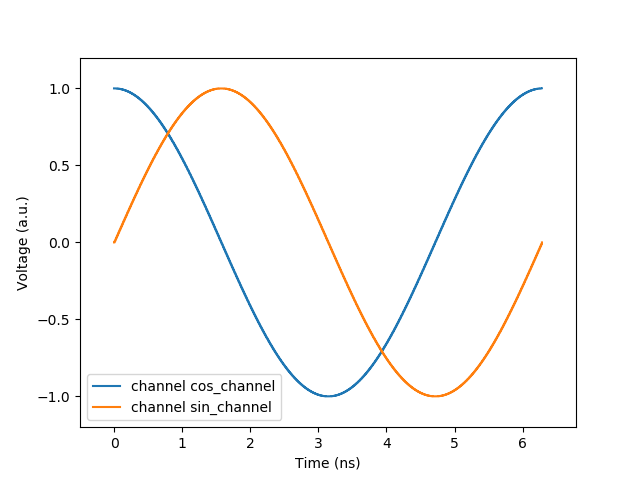

In [5]:
%matplotlib notebook
from qctoolkit.pulses.plotting import plot

parameter_values = dict(omega=1.0, a=1.0, t_duration=2*3.1415)

_ = plot(both, parameters=parameter_values, sample_rate=100)

## Automatically created mapping templates

Besides the explicit usage of the template it is also used implicitly in some cases. All implicit uses make use of the static member function `MappingPulseTemplate.from_tuple`. This 'constructor' automatically decides which mapping belongs to which entity.

In [6]:
auto_mapped = MappingPT.from_tuple((sine, sine_measurement_mapping))
print('channels:', auto_mapped.defined_channels)
print('measurements', auto_mapped.measurement_names)
print('parameters', auto_mapped.parameter_names)
print()

auto_mapped = MappingPT.from_tuple((sine, sine_measurement_mapping, partial_parameter_mapping))
print('channels:', auto_mapped.defined_channels)
print('measurements', auto_mapped.measurement_names)
print('parameters', auto_mapped.parameter_names)
print()

channels: {'default'}
measurements {'M_sin'}
parameters {'t_duration', 'omega', 'a'}

channels: {'default'}
measurements {'M_sin'}
parameters {'omega', 'a'}



In many cases, you do not need to create the MappingPT yourself. Most PulseParameters accept a mapping tuple like the ones used in the last cell. We could create our combined pulse also by using this implicit conversion:

In [7]:
both_implicit = AtomicMultiChannelPT((sine, sine_channel_mapping, sine_measurement_mapping), 
                                     (cos, cos_measurement_mapping, cos_channel_mapping))
print(both_implicit.defined_channels)
print(both_implicit.measurement_names)

{'cos_channel', 'sin_channel'}
{'M_sin', 'M_cos'}
